In [97]:
import numpy as np
from qiskit import QuantumCircuit
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit_aer import Aer


## Introduction to Optimization Problems

Optimization problems involve finding the best solution from a set of possible choices, often under certain constraints. In many real-world scenarios, such as scheduling, resource allocation, or network design, we want to maximize or minimize an objective function. 

Quantum computing offers new approaches to tackle these problems, such as using the Quantum Approximate Optimization Algorithm (QAOA) to solve combinatorial optimization tasks. This algorithm does not gaurantee quantum speed up over best existing classical methods in the general case. Nevertheless, this algorithm offers a great gateway to the world of quantum computing as it allows experimenting with quantum algorithms on a practical task with a relatively light knowledge of quantum computing. 

***

### Maximum Independent Set as an Optimization Problem

The Maximum Independent Set (MIS) problem is a classic example of a combinatorial optimization problem. Given a graph, an independent set is a subset of vertices such that no two vertices in the set are connected by an edge. The goal of the MIS problem is to find the largest possible independent set in the graph. Formally, for a graph $G = (V, E)$, the task is to select a subset of vertices $S \subseteq V$ such that for every edge $(u, v) \in E$, at most one of $u$ or $v$ is in $S$, and the size of $S$ is maximized.

This problem can be formulated as an optimization problem by introducing binary variables $x_i$ for each vertex $i$, where $x_i = 1$ if vertex $i$ is included in the independent set, and $x_i = 0$ otherwise. The objective is to maximize the sum $\sum_i x_i$, subject to the constraint that $x_i + x_j \leq 1$ for every edge $(i, j)$. Quantum algorithms like QAOA can be used to solve the MIS problem by encoding it into a Quadratic Unconstrained Binary Optimization (QUBO) form, making it suitable for quantum optimization techniques.

***

### Converting the Constraint $x_i + x_j \leq 1$ to QUBO Form

To encode the constraint $x_i + x_j \leq 1$ for the Maximum Independent Set (MIS) problem into a QUBO (Quadratic Unconstrained Binary Optimization) form, we penalize any solution where both $x_i = 1$ and $x_j = 1$. In this case, we can easily infer that the penalty term $x_i x_j$ will enfore our desired constraint. However, as a practical guide for more complex constraint we can use the following general methods. 

A standard approach is to add a penalty term for each edge $(i, j)$:
$$
P_{ij} = a(x_i + x_j) + b x_i x_j + c
$$

Here we assume that the coefficient of $x_i$ and $x_j$ is the same due to symmetry. We want $P_{ij} = 0$ when $x_i + x_j \leq 1$, and $P_{ij} > 0$ when $x_i = x_j = 1$.

Let's determine $a$, $b$, and $c$:

- If $x_i = 0, x_j = 0$: $P_{ij} = c$
- If $x_i = 1, x_j = 0$ or $x_i = 0, x_j = 1$: $P_{ij} = a + c$
- If $x_i = 1, x_j = 1$: $P_{ij} = 2a + b + c$

We want:
- $P_{ij} = 0$ for $(0,0)$ and $(1,0)$ or $(0,1)$
- $P_{ij} = \lambda$ (penalty) for $(1,1)$

Set $c = 0$, $a = 0$, $b = \lambda$:

$$
P_{ij} = \lambda x_i x_j
$$

***

### Full QUBO Objective for MIS

The MIS objective is to maximize the size of the independent set, i.e., minimize $-\sum_i x_i$, while penalizing adjacent vertices both being in the set:

$$
\text{minimize:} \quad -\sum_i x_i + \lambda \sum_{(i, j) \in E} x_i x_j
$$

where $x_i \in \{0, 1\}$ and $\lambda$ is chosen large enough to enforce the constraint.

***

### Motivation for QUBO-to-Ising Conversion

Quantum hardware often implements Hamiltonians in the Ising form, using spin variables $z_i \in \{-1, +1\}$, while combinatorial optimization problems are typically formulated as QUBO with binary variables $x_i \in \{0, 1\}$. To run QUBO problems on quantum devices, we must convert the QUBO objective to the Ising form.

### QUBO to Ising Mapping

Given a QUBO objective:
$$
E_{\text{QUBO}}(x) = x^T Q x = \sum_{i,j} Q_{ij} x_i x_j
$$
where $x_i \in \{0, 1\}$.

We map $x_i$ to spin variables $z_i \in \{-1, +1\}$ via:
$$
x_i = \frac{1 - z_i}{2}
$$

Substitute into the QUBO objective:
\begin{align*}
E_{\text{QUBO}}(x) &= \sum_{i,j} Q_{ij} \left(\frac{1 - z_i}{2}\right)\left(\frac{1 - z_j}{2}\right) \\
&= \frac{1}{4} \sum_{i,j} Q_{ij} (1 - z_i - z_j + z_i z_j) \\
&= \text{const} + \sum_i h_i z_i + \sum_{i<j} J_{ij} z_i z_j
\end{align*}

where $h_i$ and $J_{ij}$ are derived from $Q_{ij}$. This yields the Ising Hamiltonian:
$$
E_{\text{Ising}}(z) = \sum_i h_i z_i + \sum_{i<j} J_{ij} z_i z_j + \text{const}
$$

with the following coupling coefficients and local fields:
$$
J_{ij} = \frac{1}{4}(Q_{ij} + Q_{ji})
$$
$$
h_i = \frac{1}{2} Q_{ii} + \frac{1}{4} \sum_{j \neq i} (Q_{ij} + Q_{ji})
$$

***

### Example

Let's consider a graph with 5 nodes and edges: (0, 1), (1, 2), (2, 3), (0, 3), (3, 4).


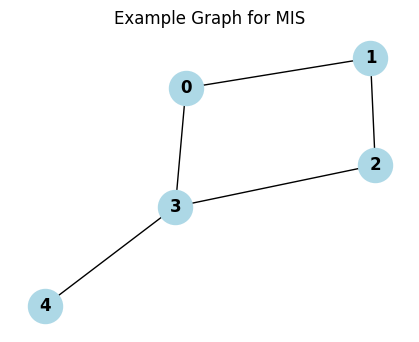

In [98]:
# Define the graph structure
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (0, 3), (3, 4)])

plt.figure(figsize=(4, 3))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=600, font_weight='bold')
plt.title("Example Graph for MIS")
plt.show()

#### QUBO Formulation
QUBO objective (with $\lambda$ as penalty, e.g., $\lambda = 1$):
$$
\text{minimize:} \quad -\sum_{i=0}^4 x_i + \lambda (x_0 x_1 + x_1 x_2 + x_2 x_3 + x_0 x_3 + x_3 x_4)
$$

In [ ]:
# Define the QUBO matrix for the given graph
Q = np.array([
    [-1, 1, 0, 1, 0],
    [1, -1, 1, 0, 0],
    [0, 1, -1, 1, 0],
    [1, 0, 1, -1, 1],
    [0, 0, 0, 1, -1]
])

n = Q.shape[0]
energies = []

def instance_energy(meas, Q):
    meas = np.array(list(map(int, meas)), dtype=int)
    diag = np.diag(Q)
    Q_ = Q - np.diag(diag)
    return np.dot(meas, np.dot(Q_, meas)) + np.dot(diag, meas) 

# Enumerate all possible bitstrings
for i in range(2 ** n):
    bitstring = format(i, f'0{n}b')
    energy = instance_energy(bitstring, Q)
    energies.append((bitstring, energy))

# Sort by increasing energy
energies.sort(key=lambda x: x[1])

# Print all solutions in order of increasing energy
print("\nBitstrings and energies (sorted):")
for bitstring, energy in energies[:5]:
    print(f"{bitstring}: {energy}")


Bitstrings and energies (sorted):
10101: -3
00101: -2
01001: -2
01010: -2
10001: -2


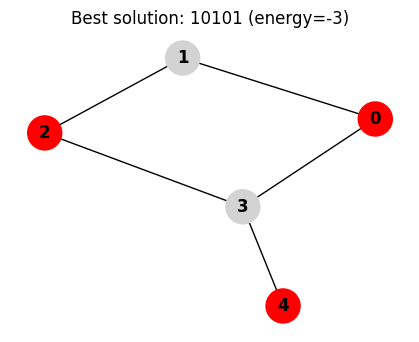

In [100]:
# Find the best solution (lowest energy)
best_bitstring, best_energy = energies[0]

# Create the graph corresponding to Q
G = nx.Graph()
G.add_nodes_from(range(n))
# Add edges where Q[i, j] > 0 and i < j (since Q is symmetric)
for i in range(n):
    for j in range(i + 1, n):
        if Q[i, j] > 0:
            G.add_edge(i, j)

# Assign colors: red for nodes in the independent set, gray otherwise
node_colors = ['red' if best_bitstring[k] == '1' else 'lightgray' for k in range(n)]

plt.figure(figsize=(4, 3))
nx.draw(G, with_labels=True, node_color=node_colors, node_size=600, font_weight='bold')
plt.title(f"Best solution: {best_bitstring} (energy={best_energy})")
plt.show()

In [101]:
# Convert bitstrings from {0,1} to {+1,-1} spin representation
def bitstring_to_spin(bs):
    # bs is a string of '0' and '1'
    return np.array([1 if b == '1' else -1 for b in bs], dtype=int)

# Calculate h and J from Q as in the markdown cell
J = 0.25 * (Q + Q.T)
h = np.zeros(n)
for k in range(n):
    h[k] = 0.5 * Q[k, k] + 0.25 * sum(Q[k, j] + Q[j, k] for j in range(n) if j != k)

# Compute Ising energy for all bitstrings and compare to QUBO energy
print("bitstring  QUBO_energy  Ising_energy")
for bs, qubo_e in energies[:5]:
    z = bitstring_to_spin(bs)
    ising_e = np.dot(h, z) + sum(J[i, j] * z[i] * z[j] for i in range(n) for j in range(i+1, n))
    print(f"{bs}    {qubo_e:10.1f}    {ising_e:11.1f}")

bitstring  QUBO_energy  Ising_energy
10101          -3.0           -3.0
00101          -2.0           -2.0
01001          -2.0           -2.0
01010          -2.0           -2.0
10001          -2.0           -2.0


### Tensor Product of Operators and Simplification

In quantum computing, the **tensor product** (also called the Kronecker product) is used to describe operators acting on multi-qubit systems. If $A$ acts on qubit 0 and $B$ acts on qubit 1, their combined action on a two-qubit system is written as $A \otimes B$.

Suppose $A$ is a $2 \times 2$ matrix acting on qubit 0, and $B$ is a $2 \times 2$ matrix acting on qubit 1. The tensor product $A \otimes B$ is a $4 \times 4$ matrix acting on the two-qubit state. If an operator acts only on one qubit, we tensor it with the identity on the other qubits. For example, $X \otimes I$ means apply Pauli $X$ to qubit 0 and do nothing to qubit 1. When writing operators, we often omit the explicit identity matrices for clarity. For example, instead of writing $X \otimes I \otimes I$ for a 3-qubit system, we simply write $X_0$, meaning "apply $X$ to qubit 0, identity elsewhere."

#### Evolving an Initial State

Suppose we start with the two-qubit state $|00\rangle$ and apply $X$ to qubit 0:
$$
|\psi_{\text{final}}\rangle = (X \otimes I) |00\rangle = X|0\rangle \otimes I|0\rangle = |1\rangle \otimes |0\rangle = |10\rangle
$$

If we apply $X$ to both qubits:
$$
(X \otimes X) |00\rangle = X|0\rangle \otimes X|0\rangle = |1\rangle \otimes |1\rangle = |11\rangle
$$

In general, $A_k$ means apply operator $A$ to qubit $k$ and identity to all others and $A_k B_l$ means apply $A$ to qubit $k$, $B$ to qubit $l$, identity elsewhere. 

***

In a cost Hamiltonian with $n$ qubits, a term like $Z_i Z_j$ represents the tensor product of $n$ operators, where Pauli $Z$ acts on qubits $i$ and $j$, and the identity operator $I$ acts on all other qubits. Explicitly, this is written as:

$$
Z_i Z_j = I \otimes \cdots \otimes Z \otimes \cdots \otimes Z \otimes \cdots \otimes I
$$

where the $Z$ appears at positions $i$ and $j$, and $I$ elsewhere. For example, for $n=4$ and $i=1$, $j=3$:

$$
Z_1 Z_3 = I \otimes Z \otimes I \otimes Z
$$

This tensor product structure ensures that each operator acts only on its designated qubit, while the identity acts on the rest. In quantum circuit notation, we often abbreviate $Z_i Z_j$ for clarity, but it always implies the full $n$-qubit tensor product.
***

### The Quantum Approximate Optimization Algorithm (QAOA)

QAOA is a hybrid quantum-classical algorithm designed to solve combinatorial optimization problems. It works by encoding the problem into a cost Hamiltonian and then using a quantum circuit to prepare a parameterized quantum state that approximates the optimal solution.

#### QAOA Ansatz
- Cost Hamiltonian $H_C$ (encodes the optimization problem)
$$
    H_C = \sum_{i} h_i Z_i + \sum_{i<j} J_{ij} Z_i Z_j
$$
- Mixer Hamiltonian $H_M$ (encourages exploration of the solution space)
$$
    H_M = \sum_{i} X_i
$$
- Parameters: $\vec{\gamma} = (\gamma_1, ..., \gamma_p)$ and $\vec{\beta} = (\beta_1, ..., \beta_p)$ for $p$ layers

The QAOA state is prepared as:
$$
|\vec{\gamma}, \vec{\beta}\rangle = \left[ \prod_{l=1}^p e^{-i \beta_l H_M} e^{-i \gamma_l H_C} \right] |+\rangle^{\otimes n}
$$
where $|+\rangle^{\otimes n}$ is the equal superposition over all $n$-qubit computational basis states which is achieved by applying a Hadamard gate on all qubits.

- **$e^{-i \gamma_l H_C}$**: Applies the cost Hamiltonian with parameter $\gamma_l$
- **$e^{-i \beta_l H_M}$**: Applies the mixer Hamiltonian with parameter $\beta_l$


#### QAOA Objective

The goal is to find parameters $(\vec{\gamma}^*, \vec{\beta}^*)$ that minimize (or maximize) the expected value of the cost Hamiltonian:
$$
F_p(\vec{\gamma}, \vec{\beta}) = \langle \vec{\gamma}, \vec{\beta} | H_C | \vec{\gamma}, \vec{\beta} \rangle
$$

This expectation is estimated by running the quantum circuit, measuring, and averaging the observed outcomes. 
A classical optimizer updates the parameters to improve the objective. QAOA alternates between applying the cost and mixer Hamiltonians, 
parameterized by $(\vec{\gamma}, \vec{\beta})$, to prepare a quantum state that encodes high-quality solutions to the optimization problem. 
The process is repeated, optimizing the parameters to maximize the probability of measuring the optimal solution.

***

The cost Hamiltonian encodes the optimization problem we want to solve on the quantum computer. In the context of QAOA for the Maximum Independent Set (MIS) problem, the cost Hamiltonian is constructed so that its ground state (lowest energy state) corresponds to the largest independent set in the graph. Each term in the Hamiltonian penalizes configurations where adjacent nodes are both included in the set, while rewarding the inclusion of nodes. Thus, finding the minimum energy configuration of the cost Hamiltonian is equivalent to solving the MIS problem for the given graph.

The exponential of the cost Hamiltonian $H_C$ is given by:
$$
e^{-i \gamma H_C}
$$
If $H_C$ is a sum of commuting terms, i.e.,
$$
H_C = \sum_k H_k
$$
and $[H_k, H_{k'}] = 0$ for all $k, k'$, then:
$$
e^{-i \gamma H_C} = e^{-i \gamma \sum_k H_k} = \prod_k e^{-i \gamma H_k}
$$

For the QAOA cost Hamiltonian (a sum of Pauli $Z$ and $ZZ$ terms) meets the condition that all terms commute and therefore we can do this factorization. The same is true about the mixer Hamiltonian.

***

### Exponentials of Pauli $Z$ and $ZZ$ as Rotations

In QAOA, we apply the exponential of the cost Hamiltonian and therefore the product of the exponential of Pauli $Z$ and $ZZ$ terms. The exponentials of these terms correspond to common quantum gates that can be implemented using common open-source tools.

For a single-qubit term $h Z_k$, the exponential is:
$$
e^{-i \gamma h Z_k} = R_z(2\gamma h)
$$
where $R_z(\theta) = e^{-i \theta Z / 2}$ is the single-qubit rotation around the $Z$ axis by angle $\theta$. Thus, exponentiating a $Z$ term is just a $Z$-rotation. The same is true about the X terms, that 

$$
e^{-i \beta h X_k} = R_x(2\beta h)
$$

where $R_x(\theta) = e^{-i \theta X / 2}$ is the single-qubit rotation around the $X$ axis by angle $\theta$.

For a two-qubit term $J Z_k Z_l$, the exponential is:
$$
e^{-i \gamma J Z_k Z_l}
$$
This is a two-qubit entangling gate. Recall that $Z_k Z_l$ is diagonal in the computational basis, with eigenvalues $\pm1$ depending on the parity of the two qubits. The action of $e^{-i \gamma J Z_k Z_l}$ is to apply a phase $e^{-i \gamma J}$ if the parity is even ($00$ or $11$), and $e^{i \gamma J}$ if the parity is odd ($01$ or $10$).

In Qiskit, this is implemented as the `RZZ` gate:
$$
RZZ(\theta) = e^{-i \frac{\theta}{2} Z \otimes Z}
$$
So, to match $e^{-i \gamma J Z_k Z_l}$, set $\theta = 2\gamma J$. The two qubit rotation operator can be expressed as the matrix product of CNOT operators and single qubit rotation. Let's show that explicitly. Suppose we have an arbitrary two-qubit state $|\psi\rangle\psi$

$$
|\psi\rangle = a |00\rangle + b |10\rangle + c |01\rangle + d |11\rangle
$$

The $e^{-i \gamma J Z_1 Z_2}$ term has the effect of introducing $\pm1$ depending on the value of the qubit 1 and 2.

$$
e^{-i \gamma J Z_1 Z_2}|\psi\rangle = a e^{-i \gamma J Z_1 Z_2}|00\rangle + b e^{-i \gamma J Z_1 Z_2}|10\rangle + c e^{-i \gamma J Z_1 Z_2}|01\rangle + d e^{-i \gamma J Z_1 Z_2}|11\rangle \\
e^{-i \gamma J Z_1 Z_2}|\psi\rangle = a e^{-i \gamma J}|00\rangle + b e^{i \gamma J}|10\rangle + c e^{i \gamma J}|01\rangle + d e^{-i \gamma J}|11\rangle
$$

The sign of the second and third term change because the $Z_1 Z_2$ product is negative for them. The `RZZ` gate is implemented as a single qubit rotation with a CNOT gate applied before and after.

$$
CX e^{-i \gamma J Z_2} CX|\psi\rangle = CX e^{-i \gamma J Z_2} CX \left( a |00\rangle + b |10\rangle + c |01\rangle + d |11\rangle \right)\\ \\
\,\\
CX e^{-i \gamma J Z_2} CX|\psi\rangle = CX e^{-i \gamma J Z_2} \left( a |00\rangle + b |11\rangle + c |01\rangle + d |10\rangle \right) \\
\,\\
CX e^{-i \gamma J Z_2} CX|\psi\rangle = CX  \left( a e^{-i \gamma J}|00\rangle + b e^{i \gamma J}|11\rangle + c e^{i \gamma J}|01\rangle + d e^{-i \gamma J}|10\rangle \right) \\
\,\\
CX e^{-i \gamma J Z_2} CX|\psi\rangle = \left( a e^{-i \gamma J}|00\rangle + b e^{i \gamma J}|10\rangle + c e^{i \gamma J}|01\rangle + d e^{-i \gamma J}|11\rangle \right) \\
\,\\
CX e^{-i \gamma J Z_2} CX|\psi\rangle = e^{-i \gamma J Z_1 Z_2}|\psi\rangle \\
$$

***

Now let's dive into coding the QAOA algorithm.

In [102]:
def qubo_matrix_to_ising_cost_terms(Q: np.ndarray) -> list:
    """
    Converts a QUBO matrix Q into a list of Pauli Z and ZZ terms
    with their coefficients, suitable for constructing an Ising Hamiltonian.

    Args:
        Q (np.ndarray): The square N x N QUBO matrix.
                               Q[i,j] represents the coefficient of x_i * x_j.

    Returns:
        list: A list of dictionaries, where each dictionary defines a term
              in the cost Hamiltonian in the format:
              {'coeff': float, 'pauli': str, 'qubits': list}
    """
    num_qubits = Q.shape[0]
    cost_terms = []

    # Calculate coefficients for ZZ terms (J_kl)
    for k in range(num_qubits):
        for l in range(k + 1, num_qubits): # Iterate for k < l
            # J_kl = 1/4 * (Q_kl + Q_lk)
            J_kl = 0.25 * (Q[k, l] + Q[l, k])
            if J_kl != 0:
                cost_terms.append({'coeff': J_kl, 'pauli': 'ZZ', 'qubits': [k, l]})

    # Calculate coefficients for Z terms (h_k)
    for k in range(num_qubits):
        h_k = 0.5 * Q[k, k] # Contribution from diagonal Q_kk
        
        # Contribution from off-diagonal terms Q_kj and Q_jk
        for j in range(num_qubits):
            if j != k:
                h_k += 0.25 * Q[k, j]
        
        if h_k != 0:
            cost_terms.append({'coeff': h_k, 'pauli': 'Z', 'qubits': [k]})

    return cost_terms


To see the list of Ising cost terms for our QUBO matrix, we call the function `qubo_matrix_to_ising_cost_terms(Q)`. This shows the decomposition of the QUBO into Ising Hamiltonian terms, with each term specifying its coefficient, Pauli type, and the qubits it acts on.


In [103]:

cost_terms = qubo_matrix_to_ising_cost_terms(Q)
for term in cost_terms:
    print(term)



{'coeff': np.float64(0.5), 'pauli': 'ZZ', 'qubits': [0, 1]}
{'coeff': np.float64(0.5), 'pauli': 'ZZ', 'qubits': [0, 3]}
{'coeff': np.float64(0.5), 'pauli': 'ZZ', 'qubits': [1, 2]}
{'coeff': np.float64(0.5), 'pauli': 'ZZ', 'qubits': [2, 3]}
{'coeff': np.float64(0.5), 'pauli': 'ZZ', 'qubits': [3, 4]}
{'coeff': np.float64(0.25), 'pauli': 'Z', 'qubits': [3]}
{'coeff': np.float64(-0.25), 'pauli': 'Z', 'qubits': [4]}


In [104]:
def create_qaoa_circuit(num_qubits: int, cost_terms: list, p: int = 1, add_measurement: bool = True,
                        params: list = None
                        ) -> QuantumCircuit:
    """
    Creates a Qiskit quantum circuit for a general QUBO problem
    using the QAOA ansatz.

    Args:
        num_qubits (int): The number of qubits, corresponding to the size of the QUBO problem.
        cost_terms (list): A list of dictionaries, where each dictionary defines a term
                           in the cost Hamiltonian.
                           Each dictionary should have:
                           - 'coeff' (float): The coefficient for the Pauli term.
                           - 'pauli' (str): 'Z' for single-qubit Z, 'ZZ' for two-qubit ZZ.
                           - 'qubits' (list): A list of qubit indices the Pauli term acts on.
                                              e.g., [0] for Z_0, [0, 1] for Z_0Z_1.
        p (int): The number of QAOA layers. Each layer consists of a cost unitary
                 and a mixer unitary.

    Returns:
        QuantumCircuit: The Qiskit quantum circuit for QAOA.
    """

    qc = QuantumCircuit(num_qubits, num_qubits)

    # Define variational parameters for each layer
    gammas = [params[i] for i in range(p)]
    betas = [params[i + p] for i in range(p)]

    # 1. Initial State Preparation: Apply Hadamard gates to all qubits
    # This creates an equal superposition of all computational basis states.
    qc.h(range(num_qubits))

    # Loop for 'p' QAOA layers
    for layer in range(p):
        # 2. Cost Unitary (U_C(gamma)): Implements the problem Hamiltonian
        # The unitary for a Pauli term P with coefficient C is e^(-i * gamma * C * P).
        # Qiskit's RZGate implements e^(-i * theta/2 * Z), so we use 2 * theta.
        # Qiskit's RZZGate implements e^(-i * theta/2 * Z_i * Z_j), so we use 2 * theta.
        for term in cost_terms:
            coeff = term['coeff']
            pauli_type = term['pauli']
            qubits = term['qubits']

            if pauli_type == 'Z':
                # Apply RZ gate for single-qubit Z terms
                # Angle is 2 * gamma * coeff
                qc.rz(2 * gammas[layer] * coeff, qubits[0])
            elif pauli_type == 'ZZ':
                # Apply RZZ gate for two-qubit ZZ terms
                # Angle is 2 * gamma * coeff
                qc.rzz(2 * gammas[layer] * coeff, qubits[0], qubits[1])
            elif pauli_type == 'ZZZ':
                i, j, k = qubits
                # Apply RZZ gate for three-qubit ZZZ terms
                # Angle is 2 * gamma * coeff
                # this is not used in this example, but for future reference if you want to work on a higher order Hamiltonian
                qc.cx(qubits[0], qubits[1])
                qc.rzz(2 * gammas[layer] * coeff, qubits[1], qubits[2])
                qc.cx(qubits[0], qubits[1])
            else:
                raise ValueError(f"Unsupported Pauli type: {pauli_type}. Only 'Z' and 'ZZ' are supported.")

        # 3. Mixer Unitary (U_M(beta)): Implements the mixing Hamiltonian
        # The standard mixer Hamiltonian is sum(X_k) over all qubits k.
        # The unitary is product(e^(-i * beta * X_k)).
        # Qiskit's RXGate implements e^(-i * theta/2 * X_k), so we use 2*beta.
        for k in range(num_qubits):
            qc.rx(2 * betas[layer], k) # Apply RX gate to each qubit

    if add_measurement:
        qc.barrier(range(num_qubits))
        qc.measure(range(num_qubits), range(num_qubits))
    return qc


To visualize the QAOA circuit for our target QUBO, we first generate the Ising cost terms and then create the circuit using `create_qaoa_circuit`. Here is how you can display the circuit for $p=1$:

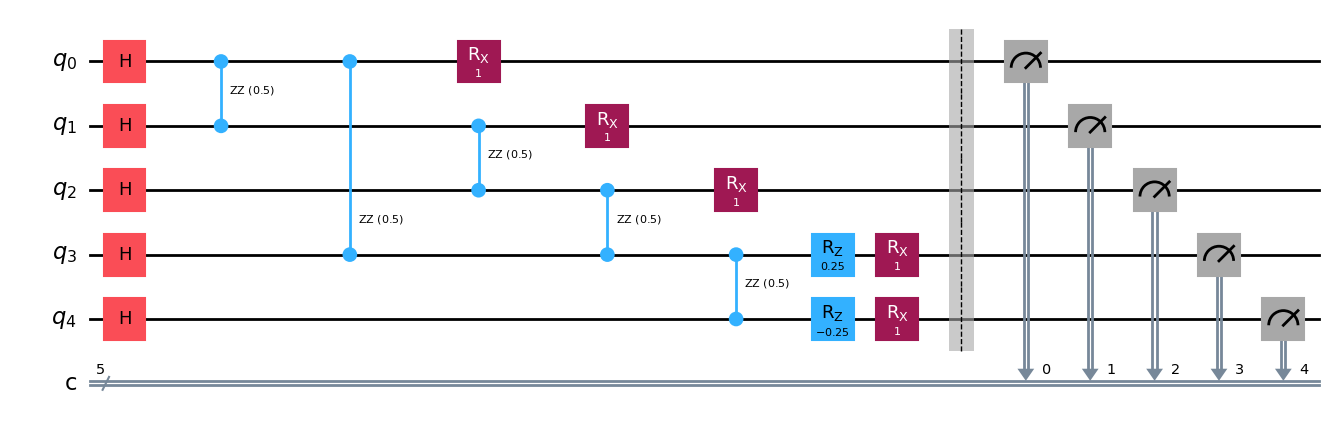

In [105]:
cost_terms = qubo_matrix_to_ising_cost_terms(Q)
qc = create_qaoa_circuit(n, cost_terms, p=1, add_measurement=True, params=[0.5, 0.5])
qc.draw('mpl')

Now we are ready to put everything together and use our QAOA implementation to solve the Maximum Independent Set problem. We have:

- Formulated the problem as a QUBO and converted it to the Ising form.
- Generated the corresponding cost Hamiltonian terms.
- Built a QAOA circuit construction function.

With these components, we can run the QAOA algorithm, optimize its parameters, and analyze the results to find high-quality solutions to our combinatorial optimization problem. Before running the QAOA optimization, we need to define a few additional helper functions:

- Bitstring inversion: Qiskit returns measurement results with the least significant bit (qubit 0) on the right, but for analysis and visualization, it is often more convenient to have qubit 0 on the left. A helper function will invert the bit order in the measurement results.
- Circuit execution: A function is needed to execute the quantum circuit on a simulator backend and return the measurement counts in the desired bit order.
- Solution evaluation: To assess the quality of solutions produced by QAOA, we require functions to compute the QUBO energy for each bitstring and to calculate the average energy over all measured outcomes.

These utilities streamline the workflow and make it easier to analyze and interpret the results of the quantum optimization algorithm.

In [106]:
def invert_counts(counts):
    # This function takes a dictionary of measurement counts (bitstrings as keys)
    # and reverses each bitstring. In Qiskit, measurement results are returned
    # with the least significant bit (qubit 0) on the right, but often we want
    # to display or process bitstrings with qubit 0 on the left. This function
    # flips the bit order for all keys in the counts dictionary.
    return {k[::-1]:v for k, v in counts.items()}


def execute(qc, backend, **kwargs):
    """
    Executes a Qiskit quantum circuit on the specified backend and returns the measurement counts
    with bitstrings in standard order (qubit 0 as leftmost bit).

    Args:
        qc (QuantumCircuit): The quantum circuit to execute.
        backend: The Qiskit backend to run the circuit on.
        **kwargs: Additional keyword arguments to pass to backend.run(), such as 'shots'.

    Returns:
        dict: A dictionary mapping bitstrings (with qubit 0 on the left) to their observed counts.
    """
    shots = kwargs.pop('shots', 10000)
    job = backend.run(qc, shots=shots, **kwargs) # Using backend.run()
    result = job.result()
    counts = result.get_counts(qc)
    return invert_counts(counts)


def compute_energy(counts, Q):
    return sum(instance_energy(meas, Q) * cnt for meas, cnt in counts.items()) / sum(counts.values())


In this section, we use Qiskit's `Aer` simulator to emulate a gate-based quantum computer. The simulator allows us to run quantum circuits and obtain measurement results as if they were executed on real quantum hardware.

To optimize the QAOA circuit, we define an objective function that takes a set of circuit parameters as input and returns the expected energy of the solution, computed as the average QUBO energy over all measured bitstrings. This expected energy serves as the cost function for the classical optimizer, which seeks to find the parameter values that minimize it. By minimizing the expected energy, we increase the probability of measuring bitstrings corresponding to high-quality (low-energy) solutions of the original optimization problem.

We then use the `scipy.optimize.minimize` function with the COBYLA method to optimize the parameters of the QAOA circuit. The optimizer iteratively updates the circuit parameters to minimize the expected energy of the measured bitstrings, as computed by our objective function. This hybrid quantum-classical approach allows us to find parameter values that maximize the probability of sampling high-quality solutions to the Maximum Independent Set problem.

In [107]:
p = 2 # Number of QAOA layers
backend = Aer.get_backend('qasm_simulator')
n = len(Q)
# 
def objective(theta):
    ising_cost_terms = qubo_matrix_to_ising_cost_terms(Q)
    qc = create_qaoa_circuit(n, ising_cost_terms, p, add_measurement=True, params=theta)
    counts = execute(qc, backend, shots=10000)
    return compute_energy(counts, Q)

init_point = np.random.uniform(0, 2 * np.pi, 2 * p)

res_sample = minimize(objective, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
print(res_sample)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5365
       x: [ 4.300e+00  2.482e+00  1.680e+00  2.637e+00]
    nfev: 56
   maxcv: 0.0


After the QAOA parameters have been optimized using the classical optimizer, we take the resulting best parameters and run the QAOA circuit again with a large number of measurement shots. This allows us to sample the output distribution and analyze which bitstrings (candidate solutions) are most frequently observed. By examining the measurement results, we can identify the most probable solutions and compare their energies to the true minimum found by brute-force search. This step provides insight into the quality of solutions produced by the QAOA algorithm and how well it approximates the optimal answer to the Maximum Independent Set problem.

In [108]:

backend = Aer.get_backend('qasm_simulator')
ising_cost_terms = qubo_matrix_to_ising_cost_terms(Q)
qc = create_qaoa_circuit(n, ising_cost_terms, p, add_measurement=True, params=res_sample.x)
counts = execute(qc, backend, shots=100000)

sorted_counts = sorted(counts.items(), key=lambda x: instance_energy(x[0], Q), reverse=False)
for bs, cnt in sorted_counts[:6]:
    energy = instance_energy(bs, Q)
    print(f"{bs}: energy={energy}, count={cnt / sum(counts.values()) * 100:.2f}%")

# Brute-force search for minimum energy bitstring
min_energy = float('inf')
min_bitstring = None
for i in range(2 ** n):
    bitstring = format(i, f'0{n}b')
    energy = instance_energy(bitstring, Q)
    if energy < min_energy:
        min_energy = energy
        min_bitstring = bitstring
print(f"Brute-force minimum: {min_bitstring} with energy={min_energy}")

10101: energy=-3, count=25.61%
00101: energy=-2, count=5.19%
01010: energy=-2, count=5.59%
01001: energy=-2, count=11.28%
10001: energy=-2, count=5.00%
10100: energy=-2, count=2.47%
Brute-force minimum: 10101 with energy=-3


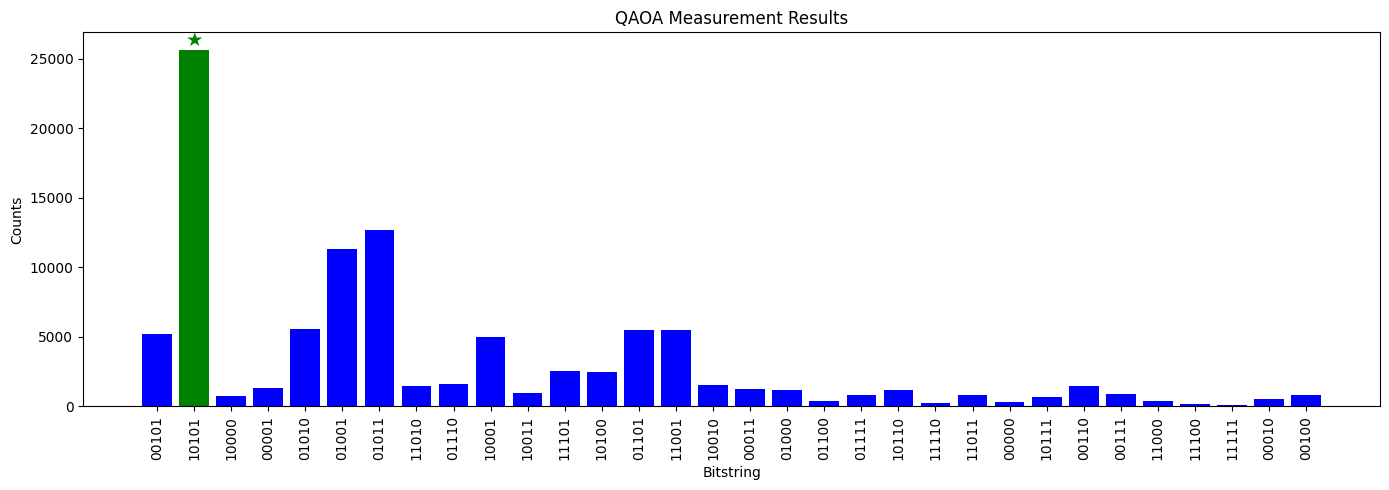

In [109]:
import matplotlib.pyplot as plt

# Prepare data for plotting
bitstrings = list(counts.keys())
frequencies = [counts[bs] for bs in bitstrings]

# Identify the best solution(s)
best_solutions = [best_bitstring] if best_bitstring in counts else []
# Optionally, highlight all bitstrings with minimum energy
min_energy_val = min(energy for _, energy in energies)
best_bitstrings = [bs for bs, energy in energies if energy == min_energy_val]

# Assign colors: highlight best solutions, others as blue
bar_colors = ['green' if bs in best_bitstrings else 'blue' for bs in bitstrings]

plt.figure(figsize=(14, 5))
bars = plt.bar(bitstrings, frequencies, color=bar_colors)
plt.xlabel('Bitstring')
plt.ylabel('Counts')
plt.title('QAOA Measurement Results')

# Annotate the best solution(s)
for idx, bs in enumerate(bitstrings):
    if bs in best_bitstrings:
        plt.text(idx, frequencies[idx], '★', ha='center', va='bottom', color='green', fontsize=14)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We now investigate how the number of QAOA layers ($p$) affects the algorithm's performance. For each value of $p$, we repeatedly optimize the QAOA circuit parameters from random initial points, run the optimized circuit, and record the success rate—defined as the probability of measuring the true optimal solution (the bitstring(s) with minimum energy). By aggregating results over multiple trials for each $p$, we can analyze the median success rate and its variability. Finally, we plot the success rate as a function of the number of QAOA layers to visualize how increasing circuit depth impacts the likelihood of finding the best solution.

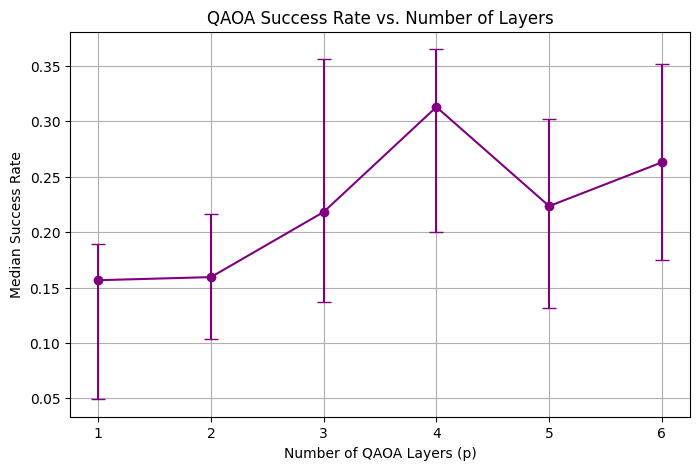

In [110]:
success_rates = []
error_bars = []

from collections import defaultdict
all_parameters = defaultdict(list)
num_trials = 20
layer_range = [1, 2, 3, 4, 5, 6]
shots = 5000  # Lower shots for speed, increase if needed

# The best solution(s) are those with minimum energy
min_energy_val = min(energy for _, energy in energies)
best_bitstrings = [bs for bs, energy in energies if energy == min_energy_val]

for p_val in layer_range:
    trial_success = []
    for _ in range(num_trials):
        # Random initial parameters for each trial
        theta_init = np.random.uniform(0, 2 * np.pi, 2 * p_val)
        ising_cost_terms = qubo_matrix_to_ising_cost_terms(Q)

        # Define objective for this p_val
        def objective(theta):
            qc = create_qaoa_circuit(n, ising_cost_terms, p=p_val, add_measurement=True, params=theta)
            counts = execute(qc, backend, shots=shots)
            return compute_energy(counts, Q)

        # Optimize QAOA parameters
        res = minimize(objective, theta_init, method='COBYLA', options={'maxiter': 500, 'disp': False})

        # Use optimized parameters to run QAOA and get counts
        qc = create_qaoa_circuit(n, ising_cost_terms, p=p_val, add_measurement=True, params=res.x)
        all_parameters[p_val].append(res.x)
        counts = execute(qc, backend, shots=shots)
        total = sum(counts.values())
        success = sum(counts.get(bs, 0) for bs in best_bitstrings) / total
        trial_success.append(success)
    # Median and error bars (25th and 75th percentiles)
    median = np.median(trial_success)
    q25 = np.percentile(trial_success, 25)
    q75 = np.percentile(trial_success, 75)
    success_rates.append(median)
    error_bars.append([[median - q25], [q75 - median]])

# Convert error_bars to numpy array for plotting
error_bars = np.array(error_bars).squeeze().T

plt.figure(figsize=(8, 5))
plt.errorbar(layer_range, success_rates, yerr=error_bars, fmt='-o', capsize=5, color='purple')
plt.xlabel('Number of QAOA Layers (p)')
plt.ylabel('Median Success Rate')
plt.title('QAOA Success Rate vs. Number of Layers')
# plt.ylim(0, 1)
plt.grid(True)
plt.show()

As observed in the results, increasing the number of QAOA layers generally improves the performance. Note that each run may result in a different trend. Sometimes the change from 1 to 2 leads to a significant improvement in the success rate of finding the optimal solution, while further increasing the number of layers yields only marginal gains. This diminishing return is especially important to consider because the computational cost and optimization time grow rapidly with circuit depth. Also, we need to make sure that the lack of improvement is not due to pre-mature optimization. Due to the larger number of parameters and the highly non-lienar nature of the optimization, we expect the optimization to not be successful every time, especially because we use finite number of samples to estimate the cost function
